<a href="https://colab.research.google.com/github/kaipak/from-eyes-to-ears/blob/master/From_Eyes_to_Ears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup the Environment

In [1]:
!git clone https://github.com/kaipak/from-eyes-to-ears.git
%cd from-eyes-to-ears
!git pull

Cloning into 'from-eyes-to-ears'...
remote: Enumerating objects: 678, done.
remote: Counting objects: 100% (678/678), done.
remote: Compressing objects: 100% (542/542), done.
remote: Total 678 (delta 167), reused 616 (delta 125), pack-reused 0
Receiving objects: 100% (678/678), 93.48 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (167/167), done.
/content/from-eyes-to-ears
Already up to date.


In [2]:
!pip install -U -f https://download.pytorch.org/whl/cu101/torch_stable.html -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html -r requirements.txt

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html, https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lsh01wq3
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lsh01wq3
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 1)) (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 2)) (0.6.0+cu101)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 3)) (0.29.17)
     |████████████████████████████████| 276kB 6.4MB/s 
     |████████████████████████████████| 6.2MB 1.4MB/s 
     |████████████████████████████████| 5.8MB 36.1MB/s 
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (from -r requirement

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import our libraries
from sound_maker import SoundMaker
from utils import *
from blended_predictor import BlendPredictor

## Model Time

### First let's setup our Panoptic Segmentation Model
We are going to use this trained out of the box because re-training would take days and a ton of horsepower.

In [0]:
po_cfg = get_cfg()
po_cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
po_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

### Train some custom data
Cool, but that model only has 80 thing and 54 stuff categories.  We want to add another custom group of things, but honestly we don't want to re-train everything.  So instead we will build a seperate mask-r-cnn model (a bit simpler and easier to find training data for) to learn these new things.

We will use a masked model so that we can overlay the results of these two models together at a pixel level.

#### We will download data generated froma a different workbook (mask_training_data)

In [5]:
from google.colab import drive
drive.mount('drive')
!rm -rf test.zip train.zip validation.zip test train validation
!cp "drive/My Drive/"*.zip .
!unzip test.zip
!unzip train.zip
!unzip validation.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive
Archive:  test.zip
   creating: test/
  inflating: test/metadata.pkl       
   creating: test/images/
  inflating: test/images/13323904b51f5644.jpg  
  inflating: test/images/1d37475594bfe9c5.jpg  
  inflating: test/images/0708923badf2ff5d.jpg  
  inflating: test/images/0a2ca221284ab461.jpg  
  inflating: test/images/14789c46e8855069.jpg  
  inflating: test/images/1caa4c7e76d166b3.jpg  
  inflating: test/images/1f93eb9aceeaf52e.jpg  
  inflating: test/images/135207e361

In [0]:
import pickle
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_dict(d):
    with open(f'{d}/metadata.pkl', 'rb') as p:
        data = pickle.load(p)["metadata"]

        # This awful list compreshension is just to change bbox_mode into the ENUB it needs to be
        return [{
            'annotations': [{
                                'bbox': a["bbox"],
                                'bbox_mode': BoxMode.XYXY_ABS,
                                'category_id': a["category_id"],
                                'iscrowd': 0,
                                'segmentation': a["segmentation"]
                            } for a in d['annotations']],
            'file_name': d['file_name'],
            'height': d['height'],
            'width': d['width'],
            'image_id': d['image_id']
        } for d in data]

In [0]:
for d in ["train", "validation", "test"]:
    DatasetCatalog.register(f"custom_{d}", lambda d=d: get_dict(d))
    with open(f'{d}/metadata.pkl', 'rb') as p:
        MetadataCatalog.get(f"custom_{d}").set(thing_classes=pickle.load(p)["categories"])

#### Lets make sure our training data is looking ok

train/images/02569b98749ec139.jpg


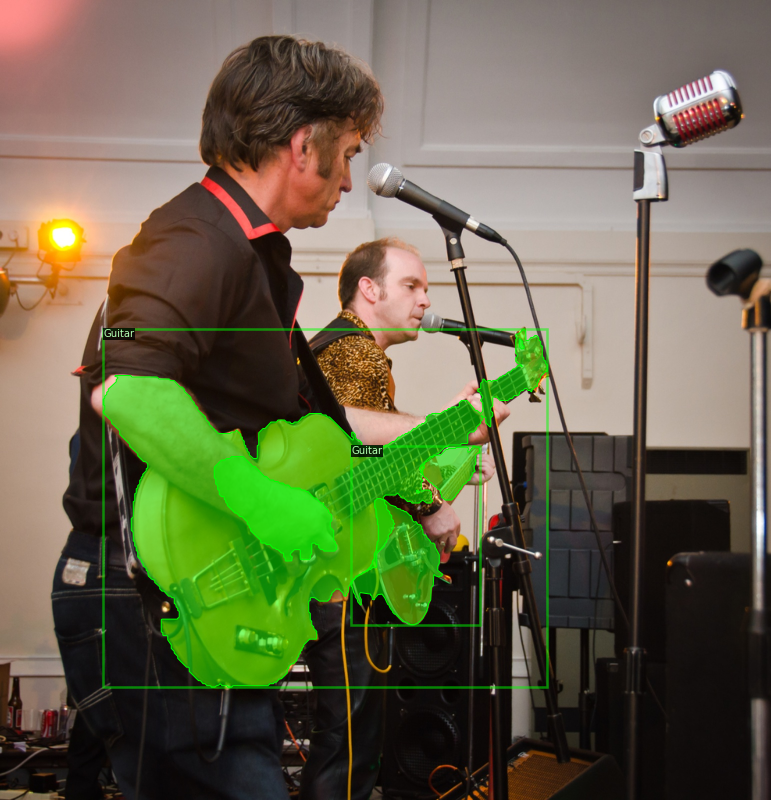

train/images/1e2bcaae7a640edc.jpg


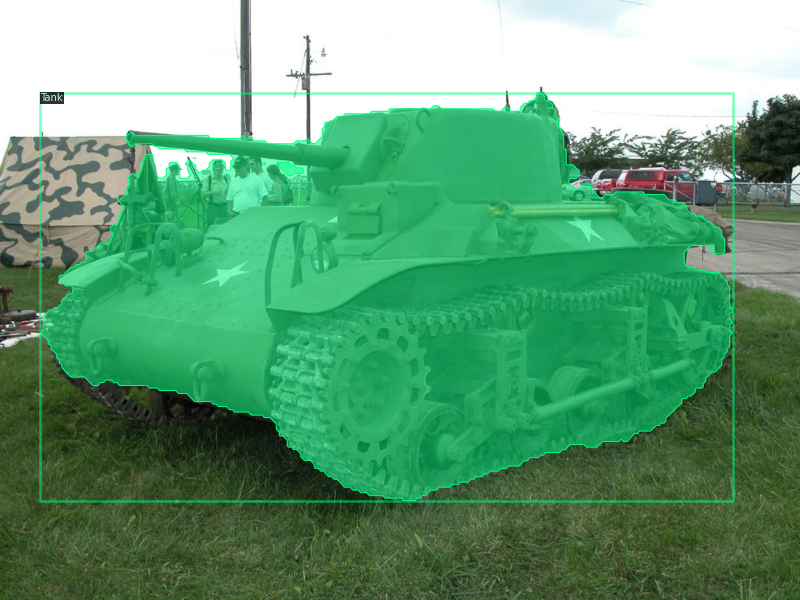

train/images/0047a49d01c337f7.jpg


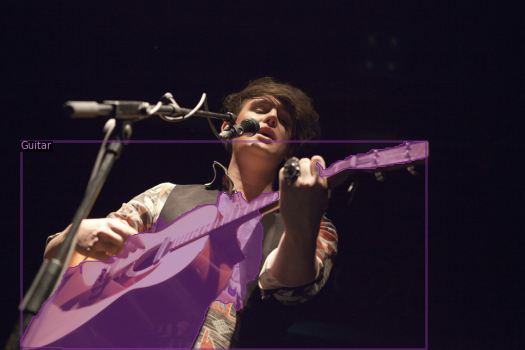

In [8]:
from detectron2.structures import BoxMode

dataset_dicts = get_dict("train")
for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("custom_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

#### Training!!!

In [11]:
from detectron2.engine import DefaultTrainer

mask_cfg = get_cfg()
mask_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
mask_cfg.DATASETS.TRAIN = ("custom_train",)
mask_cfg.DATASETS.TEST = ()
mask_cfg.DATALOADER.NUM_WORKERS = 2
mask_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
mask_cfg.SOLVER.IMS_PER_BATCH = 2
mask_cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
mask_cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
mask_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
mask_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
ß
os.makedirs(mask_cfg.OUTPUT_DIR, exist_ok=True)
mask_trainer = DefaultTrainer(mask_cfg) 
mask_trainer.resume_or_load(resume=False)
mask_trainer.train()

[05/06 16:55:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (5, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (16, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (4,) in the model! Skipped.


[05/06 16:55:37 d2.engine.train_loop]: Starting training from iteration 0
[05/06 16:55:44 d2.utils.events]:  eta: 0:11:39  iter: 19  total_loss: 2.344  loss_cls: 1.483  loss_box_reg: 0.124  loss_mask: 0.696  loss_rpn_cls: 0.016  loss_rpn_loc: 0.009  time: 0.3628  data_time: 0.0262  lr: 0.000005  max_mem: 2761M
[05/06 16:55:52 d2.utils.events]:  eta: 0:11:53  iter: 39  total_loss: 2.282  loss_cls: 1.364  loss_box_reg: 0.166  loss_mask: 0.692  loss_rpn_cls: 0.020  loss_rpn_loc: 0.010  time: 0.3673  data_time: 0.0097  lr: 0.000010  max_mem: 2761M
[05/06 16:55:59 d2.utils.events]:  eta: 0:12:04  iter: 59  total_loss: 2.083  loss_cls: 1.172  loss_box_reg: 0.225  loss_mask: 0.682  loss_rpn_cls: 0.017  loss_rpn_loc: 0.010  time: 0.3716  data_time: 0.0095  lr: 0.000015  max_mem: 2761M
[05/06 16:56:06 d2.utils.events]:  eta: 0:11:38  iter: 79  total_loss: 1.762  loss_cls: 0.928  loss_box_reg: 0.134  loss_mask: 0.681  loss_rpn_cls: 0.019  loss_rpn_loc: 0.011  time: 0.3651  data_time: 0.0091  lr:

#### Lets run some validation on our training

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

mask_cfg.MODEL.WEIGHTS = os.path.join(mask_cfg.OUTPUT_DIR, "model_final.pth")
mask_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
mask_cfg.DATASETS.TEST = ("custom_validation", )

evaluator = COCOEvaluator("custom_validation", mask_cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(mask_cfg, "custom_validation")
inference_on_dataset(mask_trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[05/06 17:07:50 d2.data.common]: Serializing 31 elements to byte tensors and concatenating them all ...
[05/06 17:07:50 d2.data.common]: Serialized dataset takes 0.15 MiB
[05/06 17:07:50 d2.evaluation.evaluator]: Start inference on 31 images
[05/06 17:07:52 d2.evaluation.evaluator]: Inference done 11/31. 0.0861 s / img. ETA=0:00:02
[05/06 17:07:55 d2.evaluation.evaluator]: Total inference time: 0:00:03.199116 (0.123043 s / img per device, on 1 devices)
[05/06 17:07:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.085137 s / img per device, on 1 devices)
[05/06 17:07:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/06 17:07:55 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[05/06 17:07:55 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE 

OrderedDict([('bbox',
              {'AP': 7.588729461181411,
               'AP-Goose': 0.0,
               'AP-Guitar': 0.519934346375814,
               'AP-Saxophone': 29.834983498349832,
               'AP-Tank': 0.0,
               'AP50': 10.696069606960695,
               'AP75': 8.415841584158414,
               'APl': 11.329974553432573,
               'APm': 0.0,
               'APs': nan}),
             ('segm',
              {'AP': 6.993949394939494,
               'AP-Goose': 0.0,
               'AP-Guitar': 0.924092409240924,
               'AP-Saxophone': 26.930693069306926,
               'AP-Tank': 0.12101210121012101,
               'AP50': 8.897139713971397,
               'AP75': 8.745874587458745,
               'APl': 10.39385556202679,
               'APm': 0.0,
               'APs': nan})])

## Prediction Time

In [13]:
predictor=BlendPredictor(po_cfg, mask_cfg)

model_final_cafdb1.pkl: 261MB [00:25, 10.3MB/s]                           


In [18]:
img, img_file = upload_file()

Provide a test image


Saving test4.jpg@642 to test4.jpg@642


In [0]:
blend_seg, blend_info = predictor.predict(img)

In [20]:
predictor.blend_md

Metadata(stuff_classes=['things', 'banner', 'blanket', 'bridge', 'cardboard', 'counter', 'curtain', 'door-stuff', 'floor-wood', 'flower', 'fruit', 'gravel', 'house', 'light', 'mirror-stuff', 'net', 'pillow', 'platform', 'playingfield', 'railroad', 'river', 'road', 'roof', 'sand', 'sea', 'shelf', 'snow', 'stairs', 'tent', 'towel', 'wall-brick', 'wall-stone', 'wall-tile', 'wall-wood', 'water', 'window-blind', 'window', 'tree', 'fence', 'ceiling', 'sky', 'cabinet', 'table', 'floor', 'pavement', 'mountain', 'grass', 'dirt', 'paper', 'food', 'building', 'rock', 'wall', 'rug'], thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'su

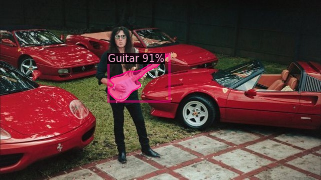

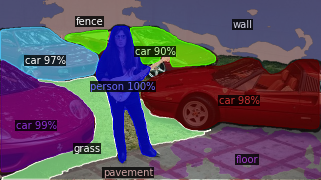

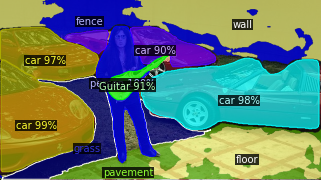

In [21]:
v = Visualizer(img[:, :, ::-1], metadata=predictor.mask_md, scale=0.5)
v = v.draw_instance_predictions(predictor.mask_output["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

v = Visualizer(img[:, :, ::-1], metadata=predictor.po_md, scale=.5)
v = v.draw_panoptic_seg_predictions(predictor.panoptic_seg.to("cpu"), predictor.panoptic_seg_info)
cv2_imshow(v.get_image()[:, :, ::-1])

v = Visualizer(img[:, :, ::-1], metadata=predictor.blend_md, scale=.5)
v = v.draw_panoptic_seg_predictions(blend_seg, blend_info)
cv2_imshow(v.get_image()[:, :, ::-1])

Lets sumarize our results

In [0]:
os.unlink(img_file)

In [0]:
seg_summary = {}
h, w, c = img.shape
size = h * w
for seg in blend_info:
    i = seg["category_id"]
    a = seg["area"]
    s = seg.get("score", 1.0)
    t = seg["isthing"]
    if i in seg_summary:
        seg_summary[i]["weighted_area"] += a * s
        seg_summary[i]["count"] += 1
    else:
        seg_summary[i] = {"weighted_area": a * s,
                          "isthing": t,
                           "count": 1,
                           "name": predictor.blend_md.thing_classes[i] if t else predictor.blend_md.stuff_classes[i]
                         }

for v in seg_summary.values():
    v["area_pct"] = v["weighted_area"] / size

In [59]:
sound_dict = dict([(v['name'], int(v['area_pct'] * 10) if v['isthing'] else 3) for v in seg_summary.values()])
sq = SoundMaker()
sounds, sound_file = sq.playsounds(sound_dict, len(sound_dict.keys()), True)

ERROR: No Results


In [60]:
from IPython.display import Audio
print(f"Generated output for the following found sounds: {sounds}")
Audio(sound_file, autoplay=True)

Generated output for the following found sounds: ['Whistling%20Person-SoundBible.com-1899769180.mp3', 'Person%20Screaming%20No-SoundBible.com-1039481659.mp3', 'Person%20Farting-SoundBible.com-1490324066.mp3', 'Person%20Farting-SoundBible.com-814467135.mp3', 'sawing-wood-daniel_simon.mp3', 'ice-skating-daniel_simon.mp3', 'fast-drawing_daniel-simion.mp3', 'electric-typewriter-daniel_simon.mp3', '9_mm_gunshot-mike-koenig-123.mp3', 'muscle-car-daniel_simon.mp3', 'cartoon-birds-2_daniel-simion.mp3', 'cartoon-telephone_daniel_simion.mp3', 'car-driveaway-daniel_simon.mp3', 'cartoon-computer_ds.mp3', 'cartoon_ricochet-Grant_Evans-861757178.mp3', 'running_feet_-Cam-942211296.mp3', 'Cargo_Train-Stephan_Schutze-1597709692.mp3', 'car_brake_crash-Cam_Martinez-567114981.mp3', 'Dump_Truck-Mike_Koenig-2078569453.mp3', 'Ice%20Cream%20Truck-SoundBible.com-1981571997.mp3', 'Truck%20Idle%20And%20Pull%20Off-SoundBible.com-1854979252.mp3', 'Truck%20Air%20Brakes-SoundBible.com-1928162780.mp3', 'Fire%20Truck-

In [61]:
unlink(sound_file)

NameError: ignored